In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

tf.get_logger().setLevel('ERROR')

In [2]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
data_file = tf.keras.utils.get_file("breast_cancer.csv", DATASET_URL)
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
df = pd.read_csv(data_file, names=col_names, header=None)

24576/19889 [=====================================] - 0s 2us/step


In [3]:
df.head()

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
df.pop("id")

0      1000025
1      1002945
2      1015425
3      1016277
4      1017023
        ...   
694     776715
695     841769
696     888820
697     897471
698     897471
Name: id, Length: 699, dtype: int64

In [5]:
df = df[df["bare_nuclei"] != '?' ]
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)

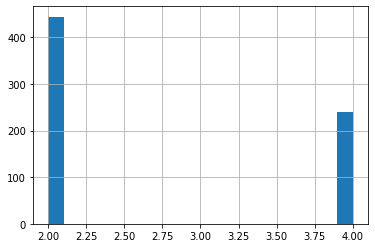

In [6]:
df['class'].hist(bins=20) 

In [7]:
df['class'] = np.where(df['class'] == 2, 0, 1)

In [8]:
train, test = train_test_split(df, test_size = 0.2)

In [9]:
train_stats = train.describe()
train_stats.pop('class')
train_stats = train_stats.transpose()

In [10]:
train_Y = train.pop("class")
test_Y = test.pop("class")

In [11]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
norm_train_X = norm(train)
norm_test_X = norm(test)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

In [13]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)

test_dataset =  test_dataset.batch(batch_size=batch_size)

In [14]:
a = enumerate(train_dataset)

print(len(list(a)))

18


In [15]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))

    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

In [19]:
from tensorflow.keras import losses
model.compile(
    optimizer='rmsprop', 
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=tf.metrics.BinaryAccuracy() )

In [21]:
history = model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=10
)

Epoch 1/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0421 - binary_accuracy: 0.9835 - val_loss: 0.1427 - val_binary_accuracy: 0.9562
Epoch 2/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0408 - binary_accuracy: 0.9872 - val_loss: 0.1492 - val_binary_accuracy: 0.9562
Epoch 3/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0400 - binary_accuracy: 0.9872 - val_loss: 0.1510 - val_binary_accuracy: 0.9562
Epoch 4/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0376 - binary_accuracy: 0.9872 - val_loss: 0.1545 - val_binary_accuracy: 0.9562
Epoch 5/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0356 - binary_accuracy: 0.9872 - val_loss: 0.1630 - val_binary_accuracy: 0.9562
Epoch 6/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0337 - binary_accuracy: 0.9872 - val_loss: 0.1644 - val_binary_accuracy: 0.9562
Epoch 7/10
18/18 [==============================] - 0s 4ms/step - loss: 0.03

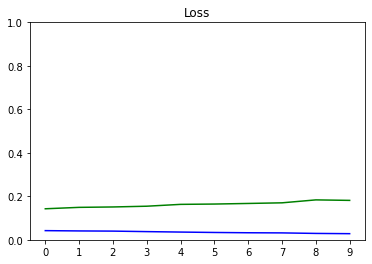

In [29]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

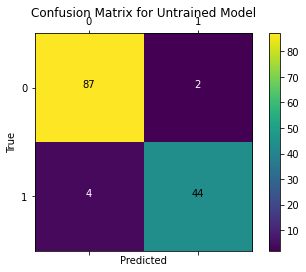

In [31]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()
test_outputs = model(norm_test_X.values)
plot_confusion_matrix(test_Y.values, tf.round(test_outputs), title='Confusion Matrix for Untrained Model')